# Reading and plotting of PSC particle data

This notebook demonstrates reading of PSC particle data and some simple analysis that can be done using Python / pandas / matplotlib.

First usual set up, import modules, etc

In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import viscid
from viscid.plot import vpyplot as vlt
import h5py
import pandas as pd
viscid.calculator.evaluator.enabled = True

%config InlineBackend.figure_format = 'retina'

In [2]:
project_dir = "/Users/kai/src/pppl-project/flatfoil/harris_700"

## Make 2-d plot first of density moment first

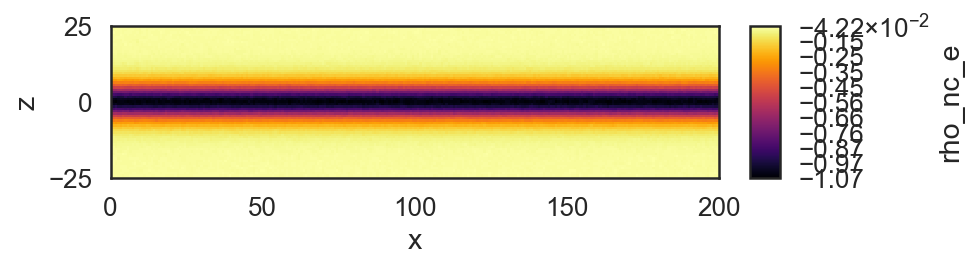

In [3]:
f = viscid.load_file(project_dir + "/pfd.xdmf", force_reload=True)
f.activate_time(0)
vlt.plot(f["rho_nc_e"], cmap="inferno");

## ParticleReader

This class really should be provided by PSC in a module (or as part of viscid). It also still needs work,
in particular:

* Support specifying regions by actual coordinates, rather than grid points
* Handle the case where only a subset of particles were written

In [4]:
class ParticleReader(object):
    def __init__(self, filename):
        file = h5py.File(filename, "r")
        self._particles = file["particles/p0/1d"]
        self._idx_begin = file["particles/p0/idx_begin"]
        self._idx_end = file["particles/p0/idx_end"]
        self.selection_lo = file["particles"].attrs["lo"]
        self.selection_hi = file["particles"].attrs["hi"]
        self.gdims = np.array(self._idx_begin.shape[3:0:-1])
        self.n_kinds = self._idx_begin.shape[0]
        
    def __xinit__(self, particles, idx_begin, idx_end, selection_lo, selection_hi):
        self._particles = particles
        self._idx_begin = idx_begin
        self._idx_end = idx_end
        self.selection_lo = selection_lo
        self.selection_hi = selection_hi
        self.gdims = np.array(idx_begin.shape[3:0:-1])
        self.n_kinds = idx_begin.shape[0]
        
    def size(self):
        return self.particles.shape[0]
        
    def inCell(self, kind, idx):
        loc = (kind, idx[2] - selection_lo[2], idx[1] - selection_lo[1], idx[0] - selection_lo[0])
        return slice(self._idx_begin[loc], self._idx_end[loc])
    
    def __getitem__(self, idx):
        if isinstance(idx, slice) or isinstance(idx, int):
            return self._particles[idx]
        elif isinstance(idx, tuple):
            return self._particleSelection(idx)
        else:
            raise "don't know how to handle this index"
            
    def _particleSelection(self, idx):
        indices = self._indices(idx)
        n = np.sum(indices[:,1] - indices[:,0])
        prts = np.zeros(n, dtype=self._particles[0].dtype)
        cnt = 0
        for r in indices:
            l = int(r[1] - r[0])
            prts[cnt:cnt+l] = self._particles[r[0]:r[1]]
            cnt += l
        return pd.DataFrame(prts)
    
    def _indices(self, idx_):
        # reorder index
        idx = (idx_[0], idx_[3], idx_[2], idx_[1])
        begin = self._idx_begin[idx].flatten()
        end = self._idx_end[idx].flatten()
        indices = [sl for sl in zip(begin, end)]
        indices = np.sort(indices, axis=0)
        # this index range could be merged where contiguous, or maybe even where
        # not contiguous but close
        return indices
        
    def __repr__(self):
        return ("ParticleReader(n={} gdims={} n_kinds={} selection=({}, {})"
                .format(self.size(), self.gdims, self.n_kinds, self.selection_lo, self.selection_hi))

## Read particles

In this particular case, read all species (`:`), and in cells `128 <= i < 130`, `j = 0`, `k = 32`, which is the center of the domain.

Particles are returned as a pandas data frame, so they can be displayed easily as a table, selections can be made, and simple plotting is provided, too.

In [5]:
p = ParticleReader(project_dir + "/prt.000000_p000000.h5")
df = p[:, 128:130, 0, 32]
df.head()

,x,y,z,px,py,pz,q,m,w
0,100.209442,1.414471,0.547419,-0.191176,-0.046516,0.165849,-1.0,1.0,0.00025
1,100.135612,-1.425988,0.714132,0.094603,-0.079601,-0.259543,-1.0,1.0,0.00025
2,100.383514,-1.144820,0.228649,-0.101998,-0.148720,0.001895,-1.0,1.0,0.00025
3,100.745880,2.161036,0.686588,0.096610,-0.129796,-0.142294,-1.0,1.0,0.00025
4,100.340401,-1.642766,0.198549,0.118109,0.129963,0.145169,-1.0,1.0,0.00025


### Selections

A simple example of making a selection: `electrons` are those particles with negative charge.

In [6]:
electrons = df[df.q < 0]

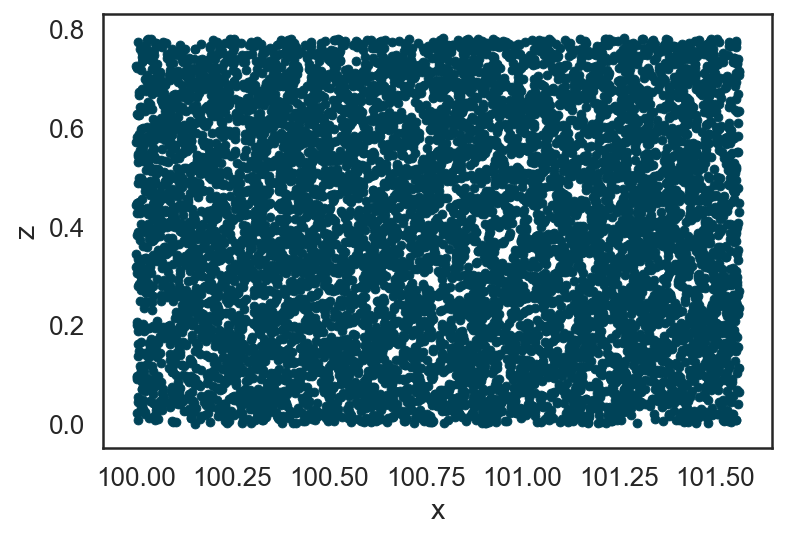

In [7]:
electrons.plot.scatter('x', 'z');

A bit more complex if contrived, example: Plot electrons moving quickly right (red) and quickly left (blue).

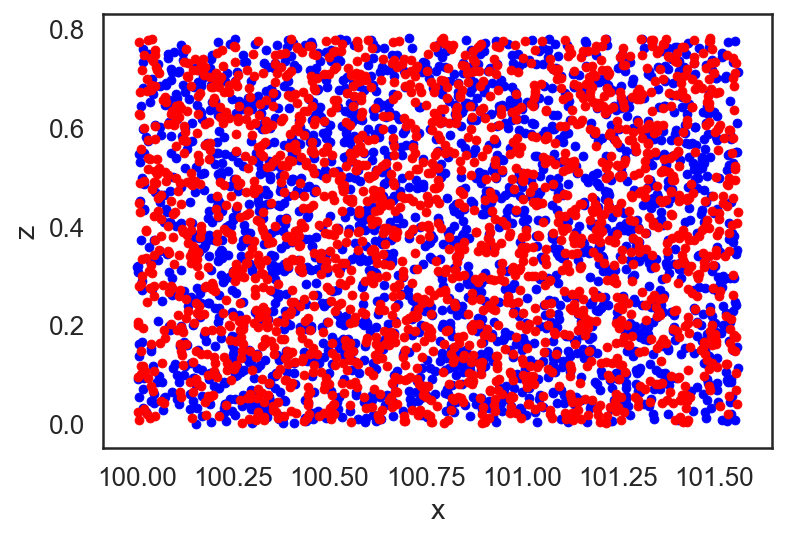

In [8]:
electrons[electrons.px < -.1].plot.scatter('x', 'z', color='b', ax=plt.gca())
electrons[electrons.px > .1].plot.scatter('x', 'z', color='r', ax=plt.gca());

## Plot a distribution function

Pandas takes care of the binning, so that's simple, too.

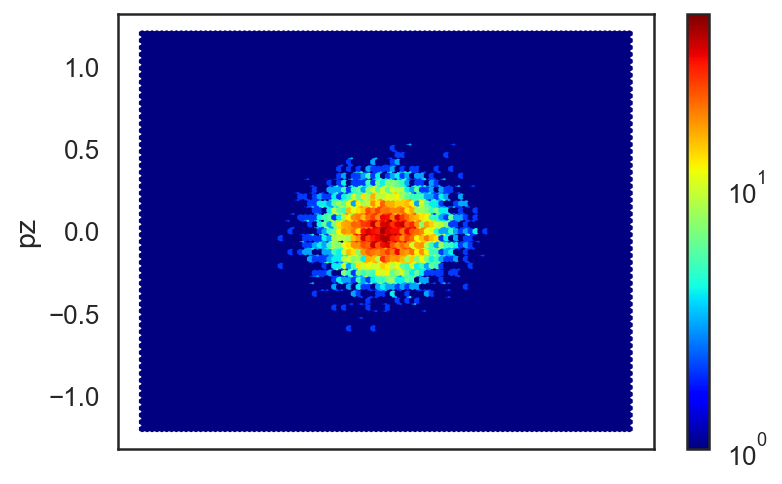

In [9]:
kwargs = {"gridsize": 100, "extent": (-1.2, 1.2, -1.2, 1.2), "cmap": 'jet'}
electrons.plot.hexbin(x='px', y='pz', bins="log", **kwargs);